# Nonlinear Classification
Under construction (3 Oct 2018)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import NeuralNetwork as NN
import Layer
import importlib
import time
from copy import deepcopy
from IPython.display import display
from ipywidgets import FloatProgress

importlib.reload(NN)
importlib.reload(Layer);

## Binary Mapping

In [2]:
# 8->4 binary mapping
noise = 0.
n_samples = 100
s = np.array([[1,0,1,0,0,1,1,0],
                         [0,1,0,1,0,1,0,1],
                         [0,1,1,0,1,0,0,1],
                         [1,0,0,0,1,0,1,1],
                         [1,0,0,1,0,1,0,1]], dtype=float)
e = np.array([[0,1,1,1],[1,1,0,1],[1,0,1,1],[1,1,1,0],[0,0,0,0]])
s = s*2. - 1.
e = e*2. - 1.
classes = len(s)
training_input = []
training_output = []
r = 0
for n in range(n_samples):
    r = np.mod(r+1, classes) #r = np.random.randint(classes)
    training_input.append(np.array(s[r], dtype=float) + noise*np.random.normal(scale=0.01,size=len(s[r])))
    training_output.append(np.array(e[r], dtype=float))

train = [training_input, training_output]

n_test_samples = 100
test_input = []
test_output = []
r = 0
for n in range(n_test_samples):
    r = np.mod(r+1, classes) #np.random.randint(classes)
    test_input.append(np.array(s[r], dtype=float) + noise*np.random.normal(scale=0.01,size=len(s[r])))
    test_output.append(np.array(e[r], dtype=float))

test = [test_input, test_output]

for x, t in zip(s,e):
    print(str(np.array(x,dtype=int))+' -> '+str(t))

[ 1 -1  1 -1 -1  1  1 -1] -> [-1.  1.  1.  1.]
[-1  1 -1  1 -1  1 -1  1] -> [ 1.  1. -1.  1.]
[-1  1  1 -1  1 -1 -1  1] -> [ 1. -1.  1.  1.]
[ 1 -1 -1 -1  1 -1  1  1] -> [ 1.  1.  1. -1.]
[ 1 -1 -1  1 -1  1 -1  1] -> [-1. -1. -1. -1.]


In [3]:
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=8))
net.AddLayer(Layer.PELayer(n=7))
net.AddLayer(Layer.PELayer(n=6))
net.AddLayer(Layer.TopPELayer(n=4))
# net.layers[1].sigma = Layer.logistic
# net.layers[1].sigma_p = Layer.logistic_p

In [4]:
train_shuffle = list(zip(train[0],train[1]))
np.random.shuffle(train_shuffle)

net.learning_tau = 2.
epochs = 10
fp = FloatProgress(min=0,max=epochs)  
display(fp)
T = 3
start_time = time.time()
for k in range(epochs):
    np.random.shuffle(train_shuffle)
    for x in train_shuffle:
        net.Infer(T, x[0], x[1])
    fp.value += 1
end_time = time.time()
print('Total time: '+str(end_time-start_time))

FloatProgress(value=0.0, max=10.0)

Total time: 143.43073153495789


In [5]:
# Test the feedback (generative) performance
beta = 0. # 1 for FF, 0 for FB
inf_layer = -1 if beta==1 else 0
fp = FloatProgress(min=0,max=len(test[0]))  
display(fp)
x_true = []
x_est = []
for x in zip(test[0], test[1]):
    net.Reset()
    if beta==1:
        x_true.append(np.array(x[1]))
        yy = net.Predict(T, x[0])
        x_est.append(np.array(yy))
    else:
        x_true.append(np.array(x[0]))
        xx = net.Generate(T, x[1])
        x_est.append(np.array(xx))
    fp.value += 1
x_true = np.array(x_true)
x_est = np.array(x_est)



FloatProgress(value=0.0)

In [6]:
fail = 0
for x,t in zip(x_true, x_est):
    if np.max(abs(x - t))>=1:
        fail += 1
    
    
    

n_trials = float(len(test[0]))
print('Accuracy '+str((n_trials-fail)/n_trials))

net.ShowState()
net.ShowWeights()

Accuracy 1.0
Layer 0 (input):
  v = [ 0.93584293 -0.93576384  1.110056   -1.0336236  -0.9960749   0.9958274
  0.9602336  -1.0159113 ]
  e = [-0.1912089   0.19178373  0.05847033  0.15486223 -0.17173454  0.17152822
 -0.1953183  -0.01483336]
Layer 1:
  v = [ 0.6569294  -0.6387692   0.85354656  0.72736835 -1.2254004   0.9617809
  0.85271865]
  e = [-0.07561826  0.16553849  0.20189387  0.28728148 -0.10358508  0.03384871
  0.03915567]
Layer 2:
  v = [ 0.6083338 -1.073481   0.7804463  0.9061462 -0.3928635 -1.3008829]
  e = [ 0.0851353   0.00318537 -0.00924032 -0.03535112 -0.01279475 -0.00817928]
Layer 3 (expectation):
  v = [-3.2262504  3.2262504  3.2262504  3.2262504]
  W01 = 
[[-0.19201262  0.08880562  0.81402916 -0.18995544 -0.5979012   0.3698556
   0.16269563 -0.5025528 ]
 [ 0.3862398  -0.1903622  -0.29907674  0.05455319  0.6725769  -0.51168126
  -0.38010782  0.48232895]
 [ 0.43427473 -0.4619229  -0.4694487   0.18041232 -0.06207323  0.05741036
   0.5199894  -0.17301925]
 [ 0.1005628  -0.4

## Ring Classes

In [125]:
# Three classes, arranged in 3 rings
# Training set
train_samples1 = 200
training_input = []
training_output = []
for n in range(train_samples1):
    rho = np.random.normal()*0.2
    theta = np.random.rand()*2.*np.pi
    x = rho*np.cos(theta)
    y = rho*np.sin(theta)
    training_input.append(np.array([x,y]))
    training_output.append(np.array([1,0.,0]))

train_samples2 = train_samples1
for n in range(train_samples2):
    rho = np.random.normal()*0.1 + 0.6
    theta = np.random.rand()*2.*np.pi
    x = rho*np.cos(theta)
    y = rho*np.sin(theta)
    training_input.append(np.array([x,y]))
    training_output.append(np.array([0.,1,0]))

train_samples3 = train_samples1
for n in range(train_samples3):
    rho = np.random.normal()*0.1 + 1.
    theta = np.random.rand()*2.*np.pi
    x = rho*np.cos(theta)
    y = rho*np.sin(theta)
    training_input.append(np.array([x,y]))
    training_output.append(np.array([0.,0,1]))

train = [np.array(training_input), np.array(training_output)]

# Test set
n_samples1 = 50
test_input = []
test_output = []
for n in range(n_samples1):
    rho = np.random.normal()*0.2
    theta = np.random.rand()*2.*np.pi
    x = rho*np.cos(theta)
    y = rho*np.sin(theta)
    test_input.append(np.array([x,y]))
    test_output.append(np.array([1,0.,0]))

n_samples2 = n_samples1
for n in range(n_samples2):
    rho = np.random.normal()*0.1 + 0.6
    theta = np.random.rand()*2.*np.pi
    x = rho*np.cos(theta)
    y = rho*np.sin(theta)
    test_input.append(np.array([x,y]))
    test_output.append(np.array([0.,1,0]))

n_samples3 = n_samples1
for n in range(n_samples3):
    rho = np.random.normal()*0.1 + 1.
    theta = np.random.rand()*2.*np.pi
    x = rho*np.cos(theta)
    y = rho*np.sin(theta)
    test_input.append(np.array([x,y]))
    test_output.append(np.array([0.,0,1]))

test = [np.array(test_input), np.array(test_output)]

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/message.c:4294)
KeyboardInterrupt


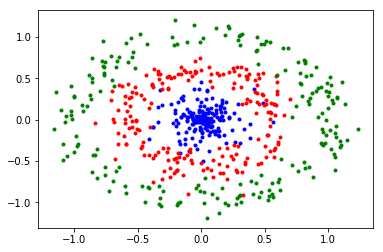

In [126]:
end1 = train_samples1
end2 = train_samples1+train_samples2
plt.plot(train[0][:end1,0], train[0][:end1,1], 'b.')
plt.plot(train[0][end1:end2,0], train[0][end1:end2,1], 'r.');
plt.plot(train[0][end2:,0], train[0][end2:,1], 'g.');

In [127]:
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=2))
net.AddLayer(Layer.PELayer(n=50))
net.AddLayer(Layer.PELayer(n=50))
net.AddLayer(Layer.TopPELayer(n=3))

## Train

In [182]:
train_shuffle = list(zip(train[0],train[1]))
np.random.shuffle(train_shuffle)

In [183]:
net.learning_tau = 2.
epochs = 10
fp = FloatProgress(min=0,max=epochs)  
display(fp)
T = 3
start_time = time.time()
for k in range(epochs):
    np.random.shuffle(train_shuffle)
    for x in train_shuffle:
        net.Infer(T, x[0], x[1])
    fp.value += 1
end_time = time.time()
print('Total time: '+str(end_time-start_time))

A Jupyter Widget

Total time: 97.2476110458374


## Test

### Run the model on the test dataset

In [ ]:
# Test the feedback (generative) performance
beta = 0. # 1 for FF, 0 for FB
inf_layer = -1 if beta==1 else 0
fp = FloatProgress(min=0,max=len(test[0]))  
display(fp)
x_true = []
x_est = []
for x in zip(test[0], test[1]):
    net.Reset()
    if beta==1:
        x_true.append(np.array(x[1]))
        yy = net.Predict(T, x[0])
        x_est.append(np.array(yy))
    else:
        x_true.append(np.array(x[0]))
        xx = net.Generate(T, x[1])
        x_est.append(np.array(xx))
    fp.value += 1
x_true = np.array(x_true)
x_est = np.array(x_est)

A Jupyter Widget

In [187]:
fail = 0
for x,t in zip(x_true, x_est):
    if np.max(np.abs(x - t))>=1.:
        fail += 1
n_trials = float(len(test[0]))
print('Accuracy '+str((n_trials-fail)/n_trials))

Accuracy 1.0


In [188]:
test[0][0]

array([-1.,  1., -1.,  1., -1.,  1., -1.,  1.])

In [197]:
idx = np.random.randint(n_test_samples)
print(net.Predict(10., test[0][idx]))
print(test[1][idx])

tensor([-0.9816,  0.9774,  0.9605,  0.9792])
[-1.  1.  1.  1.]


In [200]:
idx = np.random.randint(n_test_samples)
print(net.Generate(10., test[1][idx]))
print(test[0][idx])

tensor([ 1.0330, -1.0339,  0.7266, -0.8165, -0.9733,  0.9752,  0.7466,
        -0.6981])
[ 1. -1.  1. -1. -1.  1.  1. -1.]


In [174]:
idx = 2
print(np.round(x_true[idx:idx+5],0))
print(np.round(x_est[idx:idx+5],2))

[[ 1.  1.  1. -1.]
 [-1. -1. -1. -1.]
 [-1.  1.  1.  1.]
 [ 1.  1. -1.  1.]
 [ 1. -1.  1.  1.]]
[[0.09 0.92 0.18 0.06]
 [0.2  0.52 0.2  0.1 ]
 [0.37 0.26 0.18 0.1 ]
 [0.47 0.46 0.42 0.36]
 [0.32 0.73 0.49 0.42]]


A Jupyter Widget

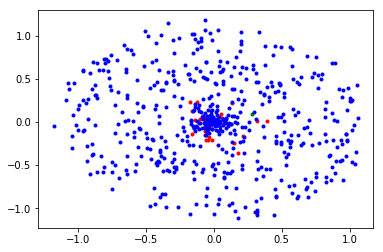

In [10]:
fp = FloatProgress(min=0, max=len(train[0]))
display(fp)
for x,t in zip(train[0], train[1]):
    y = net.Predict(10., x)
    yy = NN.OneHot(y)
    if yy[0]>0.5:
        plt.plot(x[0],x[1],'b.')
    elif yy[1]>0.5:
        plt.plot(x[0],x[1],'r.')
    else:
        plt.plot(x[0],x[1],'g.')
    fp.value += 1

A Jupyter Widget

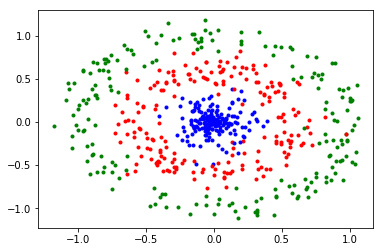

In [8]:
fp = FloatProgress(min=0, max=len(train_shuffle))
display(fp)
for x in train_shuffle:
    if x[1][0]>0.5:
        plt.plot(x[0][0],x[0][1],'b.')
    elif x[1][1]>0.5:
        plt.plot(x[0][0],x[0][1],'r.')
    else:
        plt.plot(x[0][0],x[0][1],'g.')
    fp.value += 1

In [22]:
idx = 518
print(train[1][idx])
net.Predict(10., train[0][idx])

[0. 0. 1.]


tensor([ 1.6667, -0.1989, -0.7732])

In [131]:
net.ShowBias()

  b = [0.1335559 0.1146663]
  b = [ 1.22295432e-02  5.20195870e-04  1.35570280e-02  1.09152524e-02
 -4.82401904e-03  1.04002124e-02 -1.05227195e-02  1.05511118e-02
 -5.81693603e-03 -6.68951171e-03 -3.08440998e-03  9.67296120e-03
 -1.45121536e-03 -8.47451761e-03  1.28365029e-02  2.11092886e-02
 -5.15788794e-03 -2.95260753e-02 -9.87789314e-03  2.12197080e-02
 -2.70828735e-02  8.90554767e-03 -8.05671152e-04  1.85368899e-02
  8.29417538e-03 -1.10525554e-02 -6.72775228e-03  2.13149637e-02
 -6.96162693e-03 -3.72622890e-05  9.08439606e-03 -1.56865906e-04
 -1.70638934e-02 -4.41880757e-03  1.69761926e-02 -1.16120407e-03
 -1.19285528e-02 -9.64739081e-03  1.25871776e-02  1.11266011e-02
  1.05486531e-03  3.51016968e-03  5.94086014e-03  1.01457536e-02
  1.01824561e-02 -2.02086917e-03  8.41891672e-03 -1.55731523e-02
  9.60163027e-03 -7.96670374e-03]
  b = [-0.00508129  0.00580719  0.01674417  0.00610022  0.00470639  0.00944052
 -0.00793788  0.00467956 -0.01212534 -0.02018819 -0.00409741  0.01682066


In [138]:
np.log(0.5)

-0.6931471805599453